# 4.2 손실함수(p. 111)

신경망 학습에서 사용하는 손실 함수에 대해서 알아본다.

신경망 학습에서는 현재의 상태를 하나의 지표로 표현한다.

## 4.2.1 오차제곱합

In [ ]:
import numpy as np

# y : 신경망의 출력, t : 정답 레이블
def sum_squares_error(y, t):
    return 1/2 * np.sum((y-t)**2)

# 첫 번째 케이스
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] 

y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
sum_squares_error(np.array(y), np.array(t)) # 정답에 대해서 0.6으로 예측했을 때

0.09750000000000003

In [ ]:
# 두 번째 케이스
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
sum_squares_error(np.array(y), np.array(t)) # 정답에 대해서 0.1로 예측했을 때

0.5975

정답에 대해서 0.6으로 예측했을 때는 에러값이 0.0975, 정답에 대해서 0.1로 예측했을 때 에러값은 0.5975로, 못 맞췄을 때 error 값이 훨씬 크다.

오차제곱합 기준으로는 첫 번째 추정 결과가 에러값이 더 작으므로 정답에 더 가까울 것으로 판단할 수 있음.

## 4.2.2 교차 엔트로피 오차(p. 113)

E = - sigma(t_k * logy_k) 로 표현될 수 있으며, 일반적으로는 classification에서 사용됨.

t_k가 정답 레이블이고, y_k가 신경망의 출력인데 교차 엔트로피 오차의 특징은 정답이 아닌 index의 예측값은 의미가 없다는 것. (one-hot encoding에 의해 정답이 아닌 index는 전부 0이라서 곱해지면 0이 되어버리기 때문)

그리고 교차 엔트로피 오차는 정답에 대해서 100%로 (예측값 상으로는 1로) 맞추도록 만드는 경향이 있다는 점. 

In [ ]:
# cross entropy error
# 혹시나 예측값이 0이면, log(0)이 되어버리므로 이를 방지하기 위해 delta를 더해줌
# 어차피 delta는 매우 작은 값이기 때문에 실제 loss 계산에 큰 영향을 주지 않는다.
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [ ]:
# 첫 번째 케이스
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [ ]:
# 두 번째 케이스
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

정답을 0.6의 예측값으로 맞췄을 때, CE는 0.51, 정답을 0.1의 예측값으로 맞췄을 때, CE는 2.3로 나타남.

CE가 작을수록, 정답인 label을 1에 가깝게 예측한다는 의미가 된다.

## 4.2.3 미니배치 학습(p. 115)

데이터를 배치 단위로 연산할 때, 배치 단위로 손실함수를 구해보자.

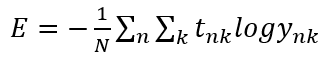

t_nk는 n번째 데이터의 k번째 값을 의미.
1개에 대해서 CE를 구하던 식하고 큰 차이는 없으나, 이제는 N개에 대해서 CE를 구하기 때문에 이를 N개로 나눠주어 평균 손실 함수를 계산한다는 점에서만 차이가 존재한다.

In [ ]:
# MNIST 데이터 다시 받아주자. 
# 이미 .gz파일은 저장되어 있다면, 해당 코드는 안 돌려도 상관 없음.

import pickle, gzip, numpy, urllib.request, json, os

# url_base : mnist 데이터가 있는 기본 url
url_base = 'http://yann.lecun.com/exdb/mnist/'

# mnist 데이터를 저장하고 싶은 위치, 원하는 위치로 지정하면 됨.
save_folder = '/content/mnist/'

# mnist의 기본 url에서 추가적으로 붙여줘야 하는 파일명들
# train-images-idx3-ubyte.gz : training image
# train-labels-idx1-ubyte.gz : training label
# t10k-images-idx3-ubyte.gz : test image
# t10k-labels-idx1-ubyte.gz : test label
key_file = ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']


# urlretrieve : 첫 번째 인자: url 위치, 두 번째 인자: the file location to copy to
# training image, training label, test image, test label을 다운받아보자.
for file_name in key_file:
    urllib.request.urlretrieve(os.path.join(url_base, file_name), os.path.join(save_folder, file_name))



In [ ]:
import gzip
import numpy as np

# 받은 .gz 파일들을 오픈해보자.
# np.frombuffer가 아닌, f.read()로만 받게 되면 bytes 데이터가 되며, 이렇게 된 경우 우리가 쓸 수 없다.
# 따라서, 이를 numpy array로 바꿔주는 것이 바로 np.frombuffer이다.
# 참고자료: https://d-tail.tistory.com/32
# offset은 어디부터 데이터를 읽을지를 나타내는데, mnist 데이터 설명에 따르면
# Image의 경우, offset을 16으로 설정해야 하는 것 같다. (그 이전은 다른 값들인듯)
with gzip.open('/content/mnist/train-images-idx3-ubyte.gz', 'rb') as f:
    x_train = np.frombuffer(f.read(), dtype = np.uint8, offset = 16)

# x_train은 numpy array 상태이며, 1차원 값으로 되어 있다.
# 따라서, 이를 28 x 28 형태로 만들어주기 위해 .reshape를 진행하게 되며,
# 이에 따라 shape는 60000, 784로 바뀌게 된다. 즉, training image는 6만장이다.
x_train = x_train.reshape(-1, 28 * 28)
print(x_train.shape)

with gzip.open('/content/mnist/train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = np.frombuffer(f.read(), dtype = np.uint8, offset = 8)

print(y_train.shape)

with gzip.open('/content/mnist/t10k-images-idx3-ubyte.gz', 'rb') as f:
    x_test = np.frombuffer(f.read(), dtype = np.uint8, offset = 16)

x_test = x_test.reshape(-1, 28 * 28)
print(x_test.shape)

with gzip.open('/content/mnist/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    y_test = np.frombuffer(f.read(), dtype = np.uint8, offset = 8)

print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [ ]:
# 기본적으로 MNIST는 label 값이 0부터 9까지로 구성되어 있다.
# p. 116의 load_mnist 코드에서는 one_hot_label = True로 지정하는데 이는 label을 one-hot encoding으로 바꾼다는 얘기다.
# 따라서, one-hot encoding을 진행해준다.

y_test_one = np.zeros((y_test.size, 10))

# One hot Encoding
for index, label in enumerate(y_test):
    # 먼저 몇 번째 label인지에 대한 index를 가지고 위치를 찾은 뒤,
    # 해당 label 위치만 1로 만들어주면 된다.
    y_test_one[index][label] = 1

# one-hot encoding 확인
print("첫 번째 라벨: ", y_test[0])
print("두 번째 라벨: ", y_test[1])
print("one-hot encoding 후 첫 번째 라벨: ", y_test_one[0])
print("one hot encoding 후 두 번째 라벨: ", y_test_one[1])


y_train_one = np.zeros((y_train.size, 10))

for index, label in enumerate(y_train):
    y_train_one[index][label] = 1

# one-hot encoding 확인
print("첫 번째 라벨: ", y_train[0])
print("두 번째 라벨: ", y_train[1])
print("one-hot encoding 후 첫 번째 라벨: ", y_train_one[0])
print("one hot encoding 후 두 번째 라벨: ", y_train_one[1])

첫 번째 라벨:  7
두 번째 라벨:  2
one-hot encoding 후 첫 번째 라벨:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
one hot encoding 후 두 번째 라벨:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
첫 번째 라벨:  5
두 번째 라벨:  0
one-hot encoding 후 첫 번째 라벨:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
one hot encoding 후 두 번째 라벨:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)

# train 전체 데이터 중 10개만 뽑는것
print(batch_mask)


x_batch = x_train[batch_mask]
y_batch = y_train_one[batch_mask]

[27343 20254 25522  7079 45884 24418  8989 10208 33049 36409]


## 4.2.4 (배치용) 교차 엔트로피 오차 구현하기(p. 118)

In [ ]:
# 2개짜리 예시로 한번 실행시켜보자.
t = np.array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

y = np.array([[0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0], [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]])

# np.log(y)를 실행하면, 모델에서 나온 예측값인 y의 모든 값에 log가 씌워진다.
print("np.log(y): ", np.log(y + 1e-7))


# t * np.log(y)를 실행하면, 정답에 해당하는 예측값만 남게 된다.
print("t * np.log(t) : ", t * np.log(y + 1e-7))

# -np.sum() 까지 붙여주면, 완전한 CE의 식이 완성된다. 그리고 2개 배치로 계산했으므로, 2로 나눠준다.
print("2 batch CE: ", -np.sum(t * np.log(y + 1e-7)) / 2)

np.log(y):  [[ -2.30258409  -2.99573027  -0.51082546 -16.11809565  -2.99573027
   -2.30258409 -16.11809565  -2.30258409 -16.11809565 -16.11809565]
 [ -2.30258409  -2.99573027  -2.30258409 -16.11809565  -2.99573027
   -2.30258409 -16.11809565  -0.51082546 -16.11809565 -16.11809565]]
t * np.log(t) :  [[-0.         -0.         -0.51082546 -0.         -0.         -0.
  -0.         -0.         -0.         -0.        ]
 [-0.         -0.         -2.30258409 -0.         -0.         -0.
  -0.         -0.         -0.         -0.        ]]
2 batch CE:  1.406704775046942


In [ ]:
def cross_entropy_error(y, t):
    # 해당 코드 없어도 잘 돌아가는데...?
    #if y.ndim == 1:
    #    t = t.reshape(1, t.size)
    #    y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [ ]:
# y와 t가 1차원인 경우
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]

cross_entropy_error(np.array(y), np.array(t))

0.0510825457099338

In [ ]:
# y와 t가 2차원(배치)의 형태인 경우
t = np.array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

y = np.array([[0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0], [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]])

cross_entropy_error(y, t)

1.406704775046942

# (추가) sample weight로 예측한 다음, CE 구해보기

해당 내용은 책에 없었지만....

Chapter 3에서 제공했던 sample weight를 이용하면

전체 데이터 중 임의의 10개 데이터에 대해 예측이 가능하니

이걸 통해서 예측해보고 CE를 계산해볼 수 있겠다고 생각했습니다.

In [ ]:
# Chapter 3에서 제공되었던 sample weight를 끌고옵니다.
# https://github.com/WegraLee/deep-learning-from-scratch/raw/master/ch03/sample_weight.pkl
urllib.request.urlretrieve('https://github.com/WegraLee/deep-learning-from-scratch/raw/master/ch03/sample_weight.pkl', os.path.join(save_folder, 'sample_weight.pkl'))

('/content/mnist/sample_weight.pkl',
 <http.client.HTTPMessage at 0x7f93da94b198>)

In [ ]:
# From Chapter 3

def init_network():
    with open('/content/mnist/sample_weight.pkl', 'rb') as f:
        network = pickle.load(f)
    return network

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    c = np.max(x)
    x_ = np.exp(x - c)
    y = x_ / np.sum(x_)
    return y

def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)

    return y

In [ ]:
network = init_network()
y_pred = []

for i in range(len(x_batch)):
    # 저장된 가중치로 예측
    y = predict(network, x_batch[i])

    # y_pred에 예측 결과를 append
    y_pred.append(list(y))

print("예측값: ", "\n", y_pred)
print("실제 정답: ", "\n", y_batch)

예측값:  
 [[0.9941385, 7.974671e-08, 0.0018961073, 0.00024021456, 1.6724672e-06, 0.0027220382, 0.0007191038, 4.3468357e-05, 0.00020851899, 3.0421752e-05], [2.0752004e-06, 2.842873e-06, 9.332469e-06, 4.7508674e-05, 0.09200752, 0.00049310975, 7.632297e-06, 0.0005432701, 0.0032558737, 0.9036309], [5.7927142e-08, 2.3618188e-06, 0.00012444034, 0.00013507176, 3.5615338e-07, 2.847703e-07, 3.8802897e-10, 0.999485, 5.582725e-07, 0.000251846], [3.526004e-05, 3.8636913e-06, 0.9996631, 1.91554e-05, 2.2146662e-06, 1.2291339e-06, 0.00025169662, 1.7279611e-06, 2.1653892e-05, 9.7458226e-08], [0.0011850706, 9.249875e-05, 0.0029870025, 0.020591918, 6.732489e-05, 0.00954383, 0.00021795818, 1.7268123e-06, 0.9647351, 0.0005775862], [0.00026207571, 1.2876336e-06, 0.9976041, 0.0018601303, 1.2089256e-08, 4.4480953e-06, 2.409255e-06, 9.623329e-06, 0.00025571242, 2.5326565e-07], [4.1881547e-11, 0.99939525, 0.00010069904, 7.468909e-05, 8.3493194e-07, 3.6736162e-06, 4.8312495e-06, 2.183928e-05, 0.0003904526, 7.6864

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


In [ ]:
# sample weight로 예측된 값과 실제 정답과의 CE 계산
cross_entropy_error(np.array(y_pred), np.array(y_batch))

0.28799916663265324